In [1]:
# Released under MIT License
#
# Copyright (c) 2023 Andrew SID Lang, Oral Roberts University, U.S.A.
#
# Copyright (c) 2023 Jan HR Woerner, Oral Roberts University, U.S.A.
#
# Copyright (c) 2023 Wei-Khiong (Wyatt) Chong, Advent Polytech Co., Ltd, Taiwan.
#
# Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated
# documentation files (the "Software"), to deal in the Software without restriction, including without limitation the
# rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to
# permit persons to whom the Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all copies or substantial portions of the
# Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO
# THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS
# OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR
# OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

import torch
from torch.utils.data import Dataset
from transformers import AutoConfig, AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import pandas as pd
import warnings
warnings.filterwarnings("ignore", message="Was asked to gather along dimension 0, but all input tensors were scalars")

In [2]:
class Input(Dataset):
    def __init__(self, i_data, i_tokenizer, i_max_length):
        self.data = i_data
        self.tokenizer = i_tokenizer
        self.max_length = i_max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        i_smiles = self.data.iloc[idx]["Standardized_SMILES"]
        i_inputs = self.tokenizer(i_smiles, return_tensors="pt", padding='max_length', truncation=True, max_length=self.max_length)
        i_inputs["input_ids"] = i_inputs["input_ids"].squeeze(0)
        i_inputs["attention_mask"] = i_inputs["attention_mask"].squeeze(0)
        if "token_type_ids" in i_inputs:
            i_inputs["token_type_ids"] = i_inputs["token_type_ids"].squeeze(0)
        i_inputs["labels"] = torch.tensor(self.data.iloc[idx]["median_WS"], dtype=torch.float).unsqueeze(0)
        return i_inputs

In [3]:
# Read in solubility data
train_data = pd.read_csv('aqua_train.csv')
test_data = pd.read_csv('aqua_test.csv')

# pick out columns
data = train_data[['Standardized_SMILES', 'median_WS']]
test = test_data[['Standardized_SMILES', 'median_WS']]

In [4]:
# Load a pretrained transformer model and tokenizer
model_name = "DeepChem/ChemBERTa-77M-MTR"
tokenizer = AutoTokenizer.from_pretrained(model_name)
config = AutoConfig.from_pretrained(model_name)
config.num_hidden_layers += 1
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1)

#see if GPU
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print("Using GPU.")
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")
# move model to the device
model.to(device) 

Some weights of the model checkpoint at DeepChem/ChemBERTa-77M-MTR were not used when initializing RobertaForSequenceClassification: ['regression.out_proj.bias', 'regression.dense.bias', 'regression.dense.weight', 'norm_std', 'regression.out_proj.weight', 'norm_mean']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight'

Using GPU.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(600, 384, padding_idx=1)
      (position_embeddings): Embedding(515, 384, padding_idx=1)
      (token_type_embeddings): Embedding(1, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.144, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-2): 3 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.109, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
             

In [5]:
# max length of SMILES over both sets
max_length = 195
# Prepare the dataset for training
train_dataset = Input(data, tokenizer,max_length)

# Set up training arguments
training_args = TrainingArguments(
    output_dir="./output",
    num_train_epochs=100, # Number of training epochs
    per_device_train_batch_size=86, # Batch size
    logging_steps=100,  # Log training metrics every 100 steps
    optim="adamw_torch", # switch optimizer to avoid warning
    seed=123, # Set a random seed for reproducibility
)

    
# Train the model
trainer = Trainer(model=model, args=training_args, train_dataset=train_dataset,)
trainer.train() 
trainer.save_model("./output") # save model to output folder

Step,Training Loss
100,6.768000
200,1.259400
300,1.048200
400,0.960900
500,0.910400
600,0.857300
700,0.819500
800,0.794000
900,0.781700
1000,0.757900


In [10]:
from transformers import pipeline
# Create a prediction pipeline

predictor = pipeline("text-classification", model=model, tokenizer=tokenizer)

# Prepare new SMILES strings for prediction
test_smiles = test['Standardized_SMILES']

# Predict properties for new SMILES strings
predictions = []
for smiles in test_smiles:
    inputs = tokenizer(smiles, return_tensors="pt", padding='max_length', truncation=True, max_length=195).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    predicted_property = outputs.logits.squeeze().item()
    predictions.append(predicted_property)

TEST SET
N: 2552
R2: 0.8054362061353308
Root Mean Square Error: 1.0125407666739181
Mean Absolute Error: 0.716880692248506
Spearman correlation: 0.8995523590904071
p-value: 0.0


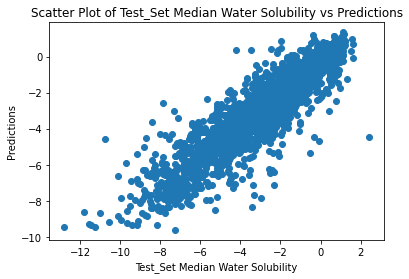

In [11]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

r_mse = mean_squared_error(test["median_WS"], predictions, squared=False)
r2 = r2_score(test["median_WS"], predictions)
mae = mean_absolute_error(test["median_WS"], predictions)

print("TEST SET")
print("N:", len(test["median_WS"]))
print("R2:", r2)
print("Root Mean Square Error:", r_mse)
print("Mean Absolute Error:", mae)

from scipy.stats import spearmanr

# assume test and predictions are two arrays of the same length
correlation, p_value = spearmanr(test["median_WS"], predictions)

print("Spearman correlation:", correlation)
print("p-value:", p_value)

import matplotlib.pyplot as plt

plt.scatter(test["median_WS"], predictions)
plt.xlabel("Test_Set Median Water Solubility")
plt.ylabel("Predictions")
plt.title("Scatter Plot of Test_Set Median Water Solubility vs Predictions")
plt.show()

In [12]:
# Prepare new SMILES strings for prediction
train_smiles = data['Standardized_SMILES']

# Predict properties for new SMILES strings
train_predictions = []
for smiles in train_smiles:
    inputs = tokenizer(smiles, return_tensors="pt", padding='max_length', truncation=True, max_length=195).to(device) 
    with torch.no_grad():
        outputs = model(**inputs)
    predicted_property = outputs.logits.squeeze().item()
    train_predictions.append(predicted_property)

TRAINING SET
N: 7655
R2: 0.871320792914473
Root Mean Square Error: 0.8098064745023944
Mean Absolute Error: 0.595570092893068
Spearman correlation: 0.9277674381474756
p-value: 0.0


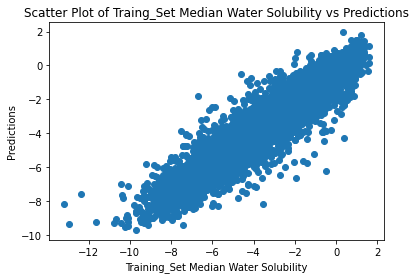

In [13]:
rmse = mean_squared_error(data["median_WS"], train_predictions, squared=False)
r2 = r2_score(data["median_WS"], train_predictions)
mae = mean_absolute_error(data["median_WS"], train_predictions)

print("TRAINING SET")
print("N:", len(data["median_WS"]))
print("R2:", r2)
print("Root Mean Square Error:", rmse)
print("Mean Absolute Error:", mae)

# assume test and predictions are two arrays of the same length
correlation, p_value = spearmanr(data["median_WS"], train_predictions)

print("Spearman correlation:", correlation)
print("p-value:", p_value)

import matplotlib.pyplot as plt

plt.scatter(data["median_WS"], train_predictions)
plt.xlabel("Training_Set Median Water Solubility")
plt.ylabel("Predictions")
plt.title("Scatter Plot of Training_Set Median Water Solubility vs Predictions")
plt.show()